<a href="https://colab.research.google.com/github/Gooogr/YOLO_Toolkit/blob/imagenet/Train_yolov4_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil 
import fnmatch

import numpy as np
import cv2
import re

from google.colab import files
from google.colab.patches import cv2_imshow

In [2]:
! pip install -q awscli

     |████████████████████████████████| 3.3MB 8.9MB/s 
     |████████████████████████████████| 6.6MB 55.0MB/s 


In [3]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Wed Sep  9 16:14:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Constants

In [4]:
CLASS_NAMES = ['Human face', 'Human hand']   # Specify labels from ImageNetv4
SAMPLES_LIMIT = 1000                         # How many image samples of earch class you need
IS_TINY = True                               # Train YOLOv4 or Tiny YOLOv4 

In [5]:
SEED = 42
np.random.seed(SEED)

## Utils

In [6]:
def yolo2voc(data, w, h):
  '''
  Convert boundary box from YOLO format to VOC
  '''
  bbox_width = float(data[3]) * w
  bbox_height = float(data[4]) * h
  center_x = float(data[1]) * w
  center_y = float(data[2]) * h
  x_min = int(center_x - (bbox_width / 2))
  y_min = int(center_y - (bbox_height / 2))
  x_max = int(center_x + (bbox_width / 2))
  y_max = int(center_y + (bbox_height / 2))
  return(x_min, y_min, x_max, y_max)

def show_data_sample(dir_path):
  '''
  Show random sample from dataset with boundary box
  '''
  txt_files = []
  img_files = []
  for txt_file in os.listdir(dir_path):
      if fnmatch.fnmatch(txt_file, '*.txt'):
        txt_files.append(txt_file)
  print('Data pairs amount:', len(txt_files))

  sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

  txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
  img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
  height = img_sample.shape[0]
  width = img_sample.shape[1]
  for line in txt_sample.readlines():
      yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
      voc_bndbox = yolo2voc(yolo_bndbox, width, height)
      img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
  img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
  cv2_imshow(img_sample)

## Dataset downloading

In [7]:
def setup_OIDv4Toolkit():
  ! git clone https://github.com/theAIGuysCode/OIDv4_ToolKit
  % cd OIDv4_ToolKit
  ! pip install -q -r  requirements.txt

In [8]:
setup_OIDv4Toolkit()

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 34.09 MiB | 8.21 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/OIDv4_ToolKit


In [9]:
class_names_query = r' '.join(name.replace(' ', '_') for name in CLASS_NAMES)

In [ ]:
# Don't change --multiclasses key value. YOLO requires that all files be in the same folder
! python3 main.py downloader -y \
 --classes {class_names_query}  \
 --type_csv train \
 --limit {SAMPLES_LIMIT} \
 --multiclasses 1

In [ ]:
# Convert annotations to normalazied YOLO version. 
with open('classes.txt', 'w') as f:
    for item in CLASS_NAMES:
        f.write("%s\n" % item)

! python convert_annotations.py

In [12]:
dataset_folder_name = r'_'.join(name for name in CLASS_NAMES)
dataset_folder_name

'Human face_Human hand'

In [ ]:
# Remove old labels. Count files amount in the dataset (images + labels).
# Name of dataset folder corresponds to the selected labels types: <Class name 1>_<Class name 2>_ ...
! rm -r /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/Label
! ls /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/ | wc -l

You have to see value roughly close to (4 * SAMPLES_LIMIT)

In [14]:
# Move dataset folder to the root of working directory
! mkdir /content/dataset

dest = '/content/dataset'
src = os.path.join('/content/OIDv4_ToolKit/OID/Dataset/train', dataset_folder_name)
src_files = os.listdir(src)

for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, dest)

In [ ]:
# Check that we succesfully move all files
! ls /content/dataset/ | wc -l

Data pairs amount: 198


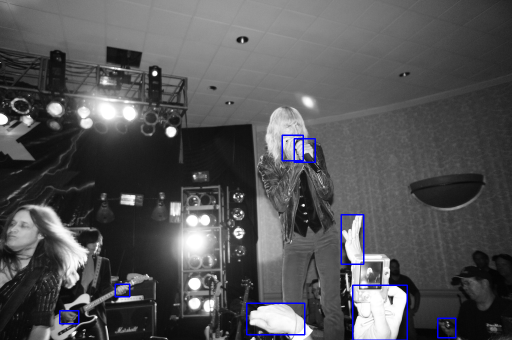

In [16]:
dir_path = '/content/dataset' 
show_data_sample(dir_path)

## Setting up YOLO Darknet

In [17]:
% cd /content

/content


In [18]:
def make_darknet():
  '''
  Make Darknet GPU version 
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

Check saving rules in ```/content/darknet/src/detector.c```, lines 384 - 403

```
 if (iteration >= (iter_save + 1000) || iteration % 1000 == 0) {
     sprintf(buff, "%s/%s_%d.weights", backup_directory, base, iteration);
 if (iteration >= (iter_save_last + 100) || (iteration % 100 == 0 && iteration > 1)) {
     sprintf(buff, "%s/%s_last.weights", backup_directory, base);
```
Change it if you need, but don't forget to ```! make``` it arter that.



In [19]:
%%capture
make_darknet()

In [20]:
def download_pretrained_weights(is_tiny):
    # AlexeAB's cfg files have already been in cfg folder
    if is_tiny:
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
    else:
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [21]:
download_pretrained_weights(IS_TINY)

In [22]:
def predict_sample(is_tiny):
    % cd /content/darknet
    ! chmod 777 ./darknet
    if is_tiny:
        ! ./darknet detector test cfg/coco.data cfg/yolov4-tiny.cfg yolov4-tiny.weights data/horses.jpg 
    else:
         ! ./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/horses.jpg 
    image = cv2.imread('predictions.jpg')
    cv2_imshow(image)

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0

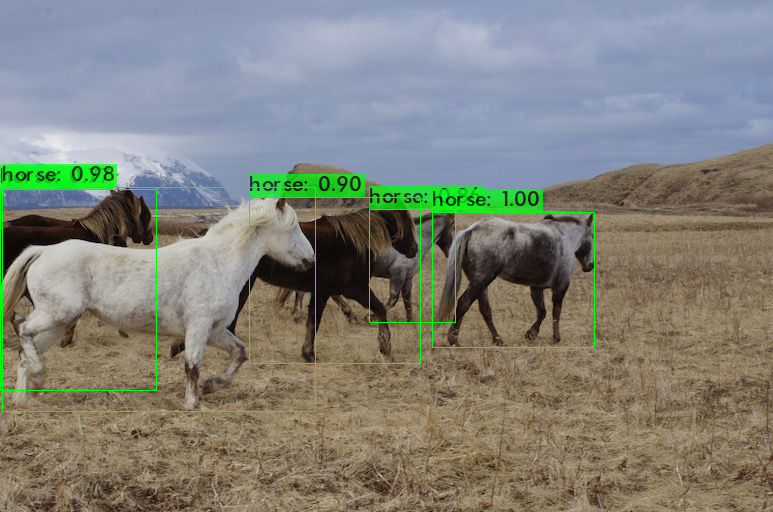

In [23]:
# check that we get working YOLO version
predict_sample(IS_TINY)

### Prepare config files

In [ ]:
% cd /content/
! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py

In [28]:
# Create train and test(validate) txt files. Split ratio will be 0.1
! python3 splitTrainAndTest.py /content/dataset

In [ ]:
! mkdir /content/darknet/custom_config_files
% cd /content/darknet/custom_config_files

> obj.names

One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

In [31]:
with open('obj.names', 'w') as f:
    for item in CLASS_NAMES:
        f.write("%s\n" % item)

In [32]:
! cat obj.names

Human face
Human hand


> yolo.data

Specify classes amount. Check pathes to other files:
```
classses = *amount of your classes*
valid  = /content/test.txt
names = /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train  = /content/train.txt
```
We will create backup folder later

In [33]:
# Custom magic function for passing python variables into files
# Taken from here: https://github.com/ipython/ipython/issues/6701#issuecomment-382640776
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [34]:
labels_amount = len(CLASS_NAMES)

In [35]:
%%writetemplate yolo.data
classses = {labels_amount}
valid = /content/test.txt
names =  /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train = /content/train.txt

In [36]:
! cat yolo.data

classses = 2
valid = /content/test.txt
names =  /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train = /content/train.txt

> yolov4.cfg

**Warning! At this step, you will probably need to make some changes to the configuration files manually!**



If you have prepaired .cfg file you can skip this step and download it directly through ```! wget``` command. 
Don't forget, that default names for .cfg file is:
* for tiny yolo - ```yolov4-tiny-custom.cfg```
* for yolo - ```yolov4-custom.cfg```

If you havn`t - follow the code:

In [37]:
%cd custom_config_files/ 

[Errno 2] No such file or directory: 'custom_config_files/'
/content/darknet/custom_config_files


In [38]:
def get_cfg_file(is_tiny):
    if is_tiny:
        ! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/imagenet/cfg_templates/yolov4-tiny-custom.cfg
    else:
        ! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/imagenet/cfg_templates/yolov4-custom.cfg

In [39]:
get_cfg_file(IS_TINY)

--2020-09-09 16:21:12--  https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/imagenet/cfg_templates/yolov4-custom.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12260 (12K) [text/plain]
Saving to: ‘yolov4-custom.cfg’

yolov4-custom.cfg   100%[===================>]  11.97K  --.-KB/s    in 0s      

2020-09-09 16:21:12 (106 MB/s) - ‘yolov4-custom.cfg’ saved [12260/12260]



Generate anchors for cfg file

In [40]:
def generate_anchors(is_tiny, width=None, height=None):
    if  is_tiny and (width is None or height is None):
        width = 416
        height = 416
    elif width is None or height is None:
        width = 608
        height = 608
    % cd /content/darknet
    ! chmod 777 ./darknet
    ! ./darknet detector calc_anchors \
    ./custom_config_files/yolo.data -num_of_clusters {labels_amount} -width {width} -height {height} -show


**Warning!** <br>
**If you are going to set custom** ```width``` **and** ```height``` **in your cfg file, you should specify them in** ```generate_anchors(IS_TINY)``` **as well.**<br>
By default:
* for YOLO v4: ```width```=608 ```height```=608
* for Tiny-YOLO v4: ```width```=416 ```height```=416

In [41]:
generate_anchors(IS_TINY)

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0

 num_of_clusters = 2, width = 608, height = 608 
classes: Using default '1'
 read labels from 179 images 
 loaded 	 image: 179 	 box: 564
 all loaded. 

 calculating k-means++ ...

 iterations = 11 


counters_per_class = 272, 22299

 avg IoU = 48.32 % 

Saving anchors to the file: anchors.txt 
anchors =  38, 52, 127,170
Unable to init server: Could not connect: Connection refused

(clusters:2921): Gtk-WARNING **: 16:21:36.767: cannot open display: 


### How to configure cfg file

You can find downloaded template of the .cfg file in <br>
```/content/darknet/custom_config_files```<br>
Double click on it and it will open in Google Colab editor window.

Necessary steps:
 * change line batch to ```batch=64```
 * change line subdivisions to
   * Tiny YOLO v4-  ```subdivisions=16```
   * YOLO v4 - ```subdivisions=32```
 * change line max_batches to ```max_batches = number_of_classes * 2000```. For example, for 3 class case max_batches = 6000.
 * change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
 * Set network size
   * for YOLO v4:  ```width=608 height=608``` or any value multiple of 32.
   * for Tiny-YOLO v4:  ```width=416 height=416``` or any value multiple of 32.
 * In every ```[yolo]``` layer: 
   * change line ```classes=number_of_classes``` in each of 3 (in tiny case - 2) ```[yolo]```-layers
   * change ```[filters=255]``` to filters=(classes + 5) * 3 in the 3 (in tiny case - 2) ```[convolutional]``` before each ```[yolo]``` layer. For example, for 3 class model filters = 24
  * replace ```anchors``` with your custom anchors values.  


Read additional information here: <br>
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects



In [42]:
# Create empty directiry for saving weights during the training
! mkdir /content/yolo_weights

### Train YOLOv4

In [43]:
def train_yolo(is_tiny):
    # Train YOLO
    % cd /content/darknet
    if is_tiny:
        ! ./darknet detector train \
        ./custom_config_files/yolo.data \
        ./custom_config_files/yolov4-tiny-custom.cfg \
        ./yolov4-tiny.conv.29 > /content/temp_train.log -dont_show  
    else:
         ! ./darknet detector train \
        ./custom_config_files/yolo.data \
        ./custom_config_files/yolov4-custom.cfg \
        ./yolov4.conv.137 > /content/temp_train.log -dont_show 

In [ ]:
train_yolo(IS_TINY)